Added State method for parametric uncertainty (Inverted Pendulum Example)

Objectives:
Compare zero lvl set evolution and 3D value function for max(v_l, v_u) with max(v_l, v_1, v_2, ..., v_max)



In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib
import pickle as pkl

from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import hj_reachability as hj
import utils

Setup Problem (dynamics, environment)

In [4]:
class inv_pend(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, uMax=10, dMin=1, dMax=2, params=None,
                 control_mode="min", disturbance_mode="max",
                 control_space=None, disturbance_space=None
                 ):
        self.uMax = jnp.array(uMax)
        self.dMin = jnp.array(dMin)
        self.dMax = jnp.array(dMax)
        if control_space is None:
            control_space = hj.sets.Box(lo=jnp.array([-self.uMax]), hi=jnp.array([self.uMax]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(lo=jnp.array([self.dMin]), hi=jnp.array([self.dMax]))
        super().__init__(params, control_mode, disturbance_mode, control_space, disturbance_space)

    def __call__(self, state, control, disturbance, time):
        dx1 = state[1]
        dx2 = -9.81*state[3]*jnp.sin(state[0]+jnp.pi)+control[0]
        dx3 = 0 #Parameteric dim, represented as nu
        return jnp.array([dx1, dx2, dx3])

    #Don't need to define control jacobian as there's only 1 control input
    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [1],
            [0],
        ])
    
    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0],
            [0],
            [0],
        ])
    
    def open_loop_dynamics(self, state, time):
        return jnp.array([state[1], -9.81*state[3]*jnp.sin(state[0]+jnp.pi), 0])

In [5]:
dyn = inv_pend(uMax=10, dMin=1, dMax=1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain = hj.sets.Box(lo=np.array([-jnp.pi, -1, 1]), hi=np.array([jnp.pi,1, 2])),
    shape = (111, 111, 5),
    # Boundary conditions matter for accuracy on the edge of the domain grid.
    # E.g. if we have an angle theta \in [0, 2pi] then we want a periodic boundary in that dim.
    periodic_dims=0,
    #boundary_conditions=(hj.boundary_conditions.extrapolate_away_from_zero,
    #                    hj.boundary_conditions.extrapolate_away_from_zero)
)
x_init = None
direction = 'backward'

In [7]:
target = jnp.array([[-0.1, 0.1], [-0.05, 0.05], [1,2.5]])
sdf = utils.build_target_sdf(target, 0.1)

sdf_values = hj.utils.multivmap(sdf, jnp.arange(grid.ndim))(grid.states)

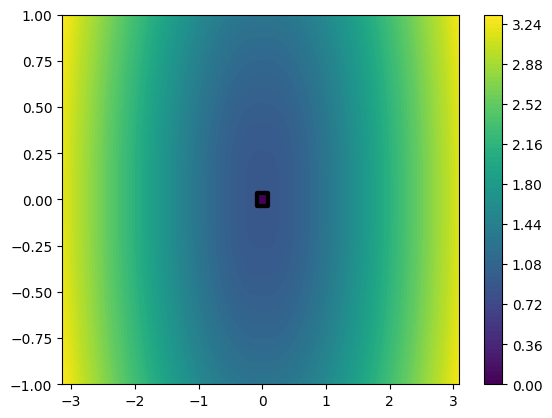

In [8]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=100)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], colors='k', linewidths=3.0)
# add colorbar
plt.colorbar(cf)

In [19]:
hamiltonian_postprocessor = lambda x : jnp.minimum(x,0) #BRT
obstacles = None

accuracy = "high"

artificial_dissipation_scheme = hj.artificial_dissipation.global_lax_friedrichs

x_init_for_solving = None

identity = lambda *x: x[-1]
if 'hamiltonian_postprocessor' not in locals():
    hamiltonian_postprocessor=identity

if 'value_postprocessor' not in locals():
    value_postprocessor=identity

solver_settings = hj.SolverSettings.with_accuracy(
    accuracy=accuracy,
    x_init=x_init_for_solving,
    artificial_dissipation_scheme=artificial_dissipation_scheme,
    hamiltonian_postprocessor=hamiltonian_postprocessor,
    value_postprocessor=value_postprocessor,
)
times = np.linspace(0, -4, 120)

In [21]:
times, target_values = hj.solve(
   solver_settings, dyn, grid, times, initial_values=sdf_values)

 17%|#7        |  0.6805/4.0 [00:19<01:35, 28.90s/sim_s]
100%|##########|  4.0000/4.0 [00:56<00:00, 14.05s/sim_s]


In [22]:
(target_values[-1] >= 0).sum() / target_values[-1].size

Array(0.62894243, dtype=float32)

In [48]:
v_l = target_values[:, :, :, 0]
v_u = target_values[:, :, :, -1]

v_int_ext = jnp.maximum(v_l,v_u)
v_int_all = jnp.max(target_values, axis=3)

(120, 111, 111)

In [51]:
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

vmax = np.abs(target_values[0]).max()
cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                 target_values[0][:,:,0].T)
#Extrema
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           v_int_ext[0,:,:].T, levels=[0], colors='green', linewidths=2)
#All
cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           v_int_all[0,:,:].T, levels=[0], colors='black', linewidths=2)
cb = fig.colorbar(cf, cax=cax)
tx = ax.set_title(f'HJR time $t=0$')
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont, cont2
    arr = v_int_ext[idi, :, :].T
    arr2 = v_int_all[idi, :, :].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], arr) #, vmax=vmax, vmin=-vmax)
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cont2.collections[0].remove()
    cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr2, levels=[0], colors='black')
    # cax.cla()
    tx.set_text('HJR time t={:.2f}'.format(np.abs(times[idi].item())))

# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)))
plt.close()
HTML(ani.to_jshtml())
#ani.save('ani.mp4')